In [29]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Install dependencies (if not already installed)
# ==========================
!pip install torch torchvision tqdm opencv-python

import os, glob, numpy as np, torch, cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm

In [31]:
def transform(g, a, normals=None):
    """
    g: [B, 4, 4] transformation matrices
    a: [B, N, 3] point cloud
    normals: optional, [B, N, 3]
    """
    R = g[..., :3, :3]  # (B, 3, 3)
    p = g[..., :3, 3]   # (B, 3)

    if len(g.size()) == len(a.size()):
        b = torch.matmul(a, R.transpose(-1, -2)) + p[..., None, :]
    else:
        raise NotImplementedError("Only batched case supported")

    if normals is not None:
        rotated_normals = normals @ R.transpose(-1, -2)
        return b, rotated_normals
    else:
        return b

In [32]:
# ----------------------------------------------------------
# Chamfer-like loss (residual-based, MAE or MSE)
# ----------------------------------------------------------
class ChamferLikeLoss(nn.Module):
    def __init__(self, loss_type="mae", reduction="mean"):
        super().__init__()
        if loss_type == "mae":
            self.criterion = nn.L1Loss(reduction=reduction)
        elif loss_type == "mse":
            self.criterion = nn.MSELoss(reduction=reduction)
        else:
            raise NotImplementedError("Only mae or mse supported")
        self.loss_type = loss_type
        self.reduction = reduction

    def forward(self, pred_pcd, tgt_pcd):
        """
        pred_pcd: [B, N, 3]
        tgt_pcd:  [B, N, 3]
        """
        return self.criterion(pred_pcd, tgt_pcd)

In [33]:
# ----------------------------------------------------------
# Heteroscedastic loss (uncertainty-aware residuals)
# ----------------------------------------------------------
class HeteroscedasticLikeLoss(nn.Module):
    def __init__(self, reduction="mean"):
        super().__init__()
        self.reduction = reduction

    def forward(self, pred_pcd, tgt_pcd, log_var):
        """
        pred_pcd: [B, N, 3]
        tgt_pcd:  [B, N, 3]
        log_var:  [B, N, 1] or [B, N]
        """
        log_var = torch.clamp(log_var, -10, 10)
        var = torch.exp(log_var)

        # squared residuals
        diff = torch.norm(pred_pcd - tgt_pcd, dim=2, p=2) ** 2  # [B, N]
        loss = diff / var.squeeze(-1) + log_var.squeeze(-1)     # [B, N]

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

In [34]:
# Step 2: Setup Repository
import os
import sys
repo_path = "/content/drive/MyDrive/Diffusion_Models/DiffusionReg-main/DiffusionReg-main"
if not os.path.exists(repo_path):
    print("Repository not found!")
    print("Please upload the DiffusionReg-main folder to your Drive at:")
    print("/content/drive/MyDrive/Diffusion_Models/DiffusionReg-main/DiffusionReg-main/DiffusionReg-main")
else:
    print(f"Repository found at: {repo_path}")

    # Add to Python path BEFORE changing directory
    sys.path.insert(0, repo_path)

    # Change to the repository directory
    os.chdir(repo_path)
    print(f"Working directory: {os.getcwd()}")
    print(f"Python path includes: {repo_path in sys.path}")


Repository found at: /content/drive/MyDrive/Diffusion_Models/DiffusionReg-main/DiffusionReg-main
Working directory: /content/drive/MyDrive/Diffusion_Models/DiffusionReg-main/DiffusionReg-main
Python path includes: True


In [35]:
# Image -> Point Cloud
# ==========================
def image_to_pointcloud(img, max_points=1024):
    h, w, c = img.shape
    xs, ys = np.meshgrid(np.arange(w), np.arange(h))
    coords = np.stack([xs, ys], axis=-1).reshape(-1, 2)
    colors = img.reshape(-1, 3)
    points = np.concatenate([coords, colors], axis=1)

    if points.shape[0] > max_points:
        idx = np.random.choice(points.shape[0], max_points, replace=False)
        points = points[idx]
    return points.astype(np.float32)


In [36]:



# Dataset
# ==========================
class ImagePointCloudDataset(Dataset):
    def __init__(self, folder, max_points=1024):
        self.paths = []
        for ext in ("*.png","*.jpg","*.jpeg","*.bmp"):
            self.paths.extend(glob.glob(os.path.join(folder, ext)))
        self.max_points = max_points

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.paths[idx])
        pc = image_to_pointcloud(img, self.max_points)
        return torch.tensor(pc, dtype=torch.float32)

In [37]:
repo_path = "/content/drive/MyDrive/Diffusion_Models/DiffusionReg-main/DiffusionReg-main"
sys.path.append(repo_path)

In [38]:

import sys
sys.path.append("/content/drive/MyDrive/Diffusion_Models/DiffusionReg-main/DiffusionReg-main")
#/content/drive/MyDrive/Diffusion_Models/DiffusionReg-main/DiffusionReg-main

from modules.DCP.dcp import DCP
from utils.diffusion_scheduler import DiffusionScheduler
from utils.options import opts

# configure opts
opts.is_debug = False
opts.model_nm = "DiffusionReg"
opts.net_type = "DiffusionDCP"
opts.device = "cuda" if torch.cuda.is_available() else "cpu"

opts.n_diff_steps = 200
opts.beta_1 = 1e-4
opts.beta_T = 0.05
opts.sigma_r = 0.05
opts.sigma_t = 0.03
opts.schedule_type = "linear"
opts.vs = DiffusionScheduler(opts)


In [39]:
class DCPWithUncertainty(nn.Module):
    def __init__(self, opts, hidden_dim=64):
        super(DCPWithUncertainty, self).__init__()
        self.dcp = DCP(opts)
        self.uncertainty_head = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # log variance per point
        )

    def forward(self, data):
        R, t = self.dcp(data)
        src = data["src_pcd"]  # [B, N, 3]
        pred_src = torch.bmm(R, src.transpose(2,1)) + t.unsqueeze(-1)
        pred_src = pred_src.transpose(2,1)
        log_var = self.uncertainty_head(pred_src)  # [B, N, 1]
        return pred_src, log_var

In [42]:
def train(train_dir, save_dir,
          epochs=20, batch_size=8, max_points=1024,
          device="cpu", gamma=1.0):

    os.makedirs(save_dir, exist_ok=True)

    train_ds = ImagePointCloudDataset(train_dir, max_points=max_points)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    model = DCPWithUncertainty(opts).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    chamfer_fn = ChamferLikeLoss(loss_type="mae", reduction="mean")
    hetero_fn  = HeteroscedasticLikeLoss(reduction="mean")

    for epoch in range(epochs):
        model.train()
        losses_total, losses_hetero, losses_chamfer = [], [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
            batch = batch.to(device)

            # src/tgt construction
            src = batch[:, :, :2]
            src = torch.cat([src, torch.zeros(src.size(0), src.size(1), 1, device=device)], dim=2)
            tgt = src.clone()

            src = (src - src.mean(dim=1, keepdim=True)) / (src.std(dim=1, keepdim=True) + 1e-6)
            tgt = (tgt - tgt.mean(dim=1, keepdim=True)) / (tgt.std(dim=1, keepdim=True) + 1e-6)

            data = {
                "src_pcd": src,
                "src_pcd_normal": torch.zeros_like(src),
                "model_pcd": tgt,
                "model_pcd_normal": torch.zeros_like(tgt)
            }

            pred_src, log_var = model(data)

            L_hetero  = hetero_fn(pred_src, tgt, log_var)
            L_chamfer = chamfer_fn(pred_src, tgt)
            L_total   = L_hetero + gamma * L_chamfer

            optimizer.zero_grad()
            L_total.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            losses_total.append(L_total.item())
            losses_hetero.append(L_hetero.item())
            losses_chamfer.append(L_chamfer.item())

        # log per-epoch averages
        print(f"Epoch {epoch} "
              f"| Total = {np.mean(losses_total):.4f} "
              f"| Hetero = {np.mean(losses_hetero):.4f} "
              f"| Chamfer = {np.mean(losses_chamfer):.4f}")

        torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch{epoch}.pth"))

    return model, chamfer_fn, hetero_fn

In [43]:
train_dir = "/content/drive/MyDrive/Diffusion_Models/mini_train"
test_dir  = "/content/drive/MyDrive/Diffusion_Models/mini_test"
save_dir  = "/content/drive/MyDrive/Diffusion_Models/mini_models"

In [44]:
train(train_dir, save_dir,epochs=20, batch_size=16, max_points=1024,device=opts.device, gamma=0.5)

Epoch 0: 100%|██████████| 132/132 [15:18<00:00,  6.96s/it]


Epoch 0 | Total = -0.2311 | Hetero = -0.2346 | Chamfer = 0.0071


Epoch 1: 100%|██████████| 132/132 [15:12<00:00,  6.91s/it]


Epoch 1 | Total = -0.4743 | Hetero = -0.4753 | Chamfer = 0.0021


Epoch 2: 100%|██████████| 132/132 [15:20<00:00,  6.97s/it]


Epoch 2 | Total = -0.7266 | Hetero = -0.7280 | Chamfer = 0.0028


Epoch 3: 100%|██████████| 132/132 [15:19<00:00,  6.97s/it]


Epoch 3 | Total = -0.9949 | Hetero = -0.9971 | Chamfer = 0.0043


Epoch 4: 100%|██████████| 132/132 [15:24<00:00,  7.00s/it]


Epoch 4 | Total = -1.2838 | Hetero = -1.2863 | Chamfer = 0.0050


Epoch 5: 100%|██████████| 132/132 [15:21<00:00,  6.98s/it]


Epoch 5 | Total = -1.5968 | Hetero = -1.5992 | Chamfer = 0.0048


Epoch 6: 100%|██████████| 132/132 [15:27<00:00,  7.03s/it]


Epoch 6 | Total = -1.9361 | Hetero = -1.9382 | Chamfer = 0.0042


Epoch 7: 100%|██████████| 132/132 [15:26<00:00,  7.02s/it]


Epoch 7 | Total = -2.3041 | Hetero = -2.3057 | Chamfer = 0.0033


Epoch 8: 100%|██████████| 132/132 [15:31<00:00,  7.06s/it]


Epoch 8 | Total = -2.7009 | Hetero = -2.7022 | Chamfer = 0.0025


Epoch 9: 100%|██████████| 132/132 [15:30<00:00,  7.05s/it]


Epoch 9 | Total = -3.1270 | Hetero = -3.1280 | Chamfer = 0.0018


Epoch 10: 100%|██████████| 132/132 [15:33<00:00,  7.07s/it]


Epoch 10 | Total = -3.5823 | Hetero = -3.5830 | Chamfer = 0.0013


Epoch 11: 100%|██████████| 132/132 [15:32<00:00,  7.07s/it]


Epoch 11 | Total = -4.0664 | Hetero = -4.0668 | Chamfer = 0.0008


Epoch 12: 100%|██████████| 132/132 [15:36<00:00,  7.10s/it]


Epoch 12 | Total = -4.5785 | Hetero = -4.5788 | Chamfer = 0.0005


Epoch 13: 100%|██████████| 132/132 [15:36<00:00,  7.10s/it]


Epoch 13 | Total = -5.1194 | Hetero = -5.1195 | Chamfer = 0.0003


Epoch 14: 100%|██████████| 132/132 [15:40<00:00,  7.12s/it]


Epoch 14 | Total = -5.6825 | Hetero = -5.6825 | Chamfer = 0.0002


Epoch 15: 100%|██████████| 132/132 [15:39<00:00,  7.12s/it]


Epoch 15 | Total = -6.2584 | Hetero = -6.2585 | Chamfer = 0.0001


Epoch 16: 100%|██████████| 132/132 [15:39<00:00,  7.12s/it]


Epoch 16 | Total = -6.8351 | Hetero = -6.8351 | Chamfer = 0.0000


Epoch 17: 100%|██████████| 132/132 [15:45<00:00,  7.16s/it]


Epoch 17 | Total = -7.4006 | Hetero = -7.4006 | Chamfer = 0.0000


Epoch 18: 100%|██████████| 132/132 [15:44<00:00,  7.15s/it]


Epoch 18 | Total = -7.9300 | Hetero = -7.9300 | Chamfer = 0.0000


Epoch 19: 100%|██████████| 132/132 [15:44<00:00,  7.15s/it]


Epoch 19 | Total = -8.4154 | Hetero = -8.4154 | Chamfer = 0.0000


(DCPWithUncertainty(
   (dcp): DCP(
     (emb_nn): FeatExtractionEarlyFusion(
       (prepool): Sequential(
         (0): Conv2d(10, 96, kernel_size=(1, 1), stride=(1, 1))
         (1): GroupNorm(8, 96, eps=1e-05, affine=True)
         (2): ReLU()
         (3): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
         (4): GroupNorm(8, 96, eps=1e-05, affine=True)
         (5): ReLU()
         (6): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
         (7): GroupNorm(8, 192, eps=1e-05, affine=True)
         (8): ReLU()
       )
       (postpool): Sequential(
         (0): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
         (1): GroupNorm(8, 192, eps=1e-05, affine=True)
         (2): ReLU()
         (3): Conv1d(192, 96, kernel_size=(1,), stride=(1,))
         (4): GroupNorm(8, 96, eps=1e-05, affine=True)
         (5): ReLU()
         (6): Conv1d(96, 96, kernel_size=(1,), stride=(1,))
       )
     )
     (pointer): Transformer(
       (model): EncoderDecoder(
         (encoder

In [47]:
def evaluate(model, test_dir, batch_size=8, max_points=1024,device="cpu", gamma=1.0,chamfer_fn=None, hetero_fn=None):

    test_ds = ImagePointCloudDataset(test_dir, max_points=max_points)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    model.eval()
    losses_total, losses_hetero, losses_chamfer = [], [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            batch = batch.to(device)

            src = batch[:, :, :2]
            src = torch.cat([src, torch.zeros(src.size(0), src.size(1), 1, device=device)], dim=2)
            tgt = src.clone()

            src = (src - src.mean(dim=1, keepdim=True)) / (src.std(dim=1, keepdim=True) + 1e-6)
            tgt = (tgt - tgt.mean(dim=1, keepdim=True)) / (tgt.std(dim=1, keepdim=True) + 1e-6)

            data = {
                "src_pcd": src,
                "src_pcd_normal": torch.zeros_like(src),
                "model_pcd": tgt,
                "model_pcd_normal": torch.zeros_like(tgt)
            }

            pred_src, log_var = model(data)

            L_hetero  = hetero_fn(pred_src, tgt, log_var)
            L_chamfer = chamfer_fn(pred_src, tgt)
            L_total   = L_hetero + gamma * L_chamfer

            losses_total.append(L_total.item())
            losses_hetero.append(L_hetero.item())
            losses_chamfer.append(L_chamfer.item())

    print(f"Evaluation Results "
          f"| Total = {np.mean(losses_total):.4f} "
          f"| Hetero = {np.mean(losses_hetero):.4f} "
          f"| Chamfer = {np.mean(losses_chamfer):.4f}")


In [48]:
# Recreate the model
model = DCPWithUncertainty(opts).to(opts.device)

# Load the last checkpoint
ckpt_path = os.path.join(save_dir, "model_epoch19.pth")  # or whichever you want
model.load_state_dict(torch.load(ckpt_path, map_location=opts.device))

<All keys matched successfully>

In [51]:
# Evaluate

model.eval()

DCPWithUncertainty(
  (dcp): DCP(
    (emb_nn): FeatExtractionEarlyFusion(
      (prepool): Sequential(
        (0): Conv2d(10, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): GroupNorm(8, 96, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
        (4): GroupNorm(8, 96, eps=1e-05, affine=True)
        (5): ReLU()
        (6): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
        (7): GroupNorm(8, 192, eps=1e-05, affine=True)
        (8): ReLU()
      )
      (postpool): Sequential(
        (0): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
        (1): GroupNorm(8, 192, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv1d(192, 96, kernel_size=(1,), stride=(1,))
        (4): GroupNorm(8, 96, eps=1e-05, affine=True)
        (5): ReLU()
        (6): Conv1d(96, 96, kernel_size=(1,), stride=(1,))
      )
    )
    (pointer): Transformer(
      (model): EncoderDecoder(
        (encoder): Encoder(
          (laye

In [52]:
# Recreate loss functions
chamfer_fn = ChamferLikeLoss(loss_type="mae", reduction="mean")
hetero_fn  = HeteroscedasticLikeLoss(reduction="mean")

In [53]:
# Evaluate
evaluate(model, test_dir,batch_size=16, max_points=1024,device=opts.device, gamma=0.5,chamfer_fn=chamfer_fn, hetero_fn=hetero_fn)

Evaluating: 100%|██████████| 19/19 [01:20<00:00,  4.23s/it]

Evaluation Results | Total = -8.6409 | Hetero = -8.6409 | Chamfer = 0.0000


In [ ]:
#######################################################################################################################################

Visualization Of Results

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_alignment(model, test_loader, device="cpu", num_examples=3):
    """
    Visualize before vs after alignment for a few test examples.
    - Blue: Source / Predicted Source
    - Red: Target
    """
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= num_examples:
                break

            batch = batch.to(device)

            # Construct src & tgt
            src = batch[:, :, :2]
            src = torch.cat([src, torch.zeros(src.size(0), src.size(1), 1, device=device)], dim=2)
            tgt = src.clone()

            # Normalize
            src = (src - src.mean(dim=1, keepdim=True)) / (src.std(dim=1, keepdim=True) + 1e-6)
            tgt = (tgt - tgt.mean(dim=1, keepdim=True)) / (tgt.std(dim=1, keepdim=True) + 1e-6)

            data = {
                "src_pcd": src,
                "src_pcd_normal": torch.zeros_like(src),
                "model_pcd": tgt,
                "model_pcd_normal": torch.zeros_like(tgt)
            }

            # Forward pass
            pred_src, log_var = model(data)

            # Convert to numpy
            src_np  = src[0].cpu().numpy()
            tgt_np  = tgt[0].cpu().numpy()
            pred_np = pred_src[0].cpu().numpy()

            # Plot before vs after
            fig = plt.figure(figsize=(12,5))

            # Before alignment
            ax1 = fig.add_subplot(121, projection="3d")
            ax1.scatter(src_np[:,0], src_np[:,1], src_np[:,2], c="blue", s=5, label="Source")
            ax1.scatter(tgt_np[:,0], tgt_np[:,1], tgt_np[:,2], c="red", s=5, label="Target")
            ax1.set_title("Before Alignment")
            ax1.legend()

            # After alignment
            ax2 = fig.add_subplot(122, projection="3d")
            ax2.scatter(pred_np[:,0], pred_np[:,1], pred_np[:,2], c="blue", s=5, label="Predicted Source")
            ax2.scatter(tgt_np[:,0], tgt_np[:,1], tgt_np[:,2], c="red", s=5, label="Target")
            ax2.set_title("After Alignment")
            ax2.legend()

            plt.show()


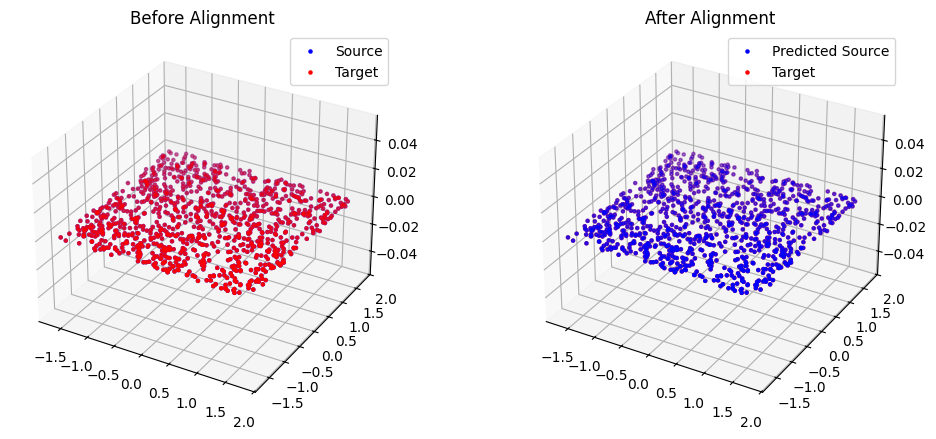

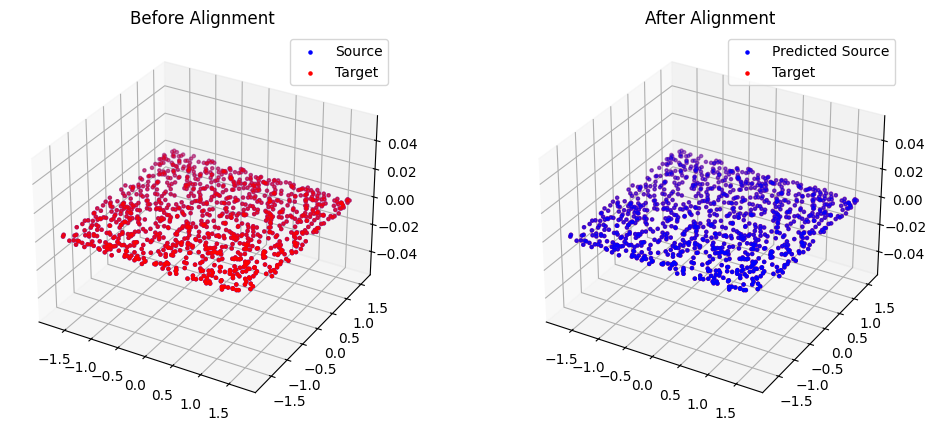

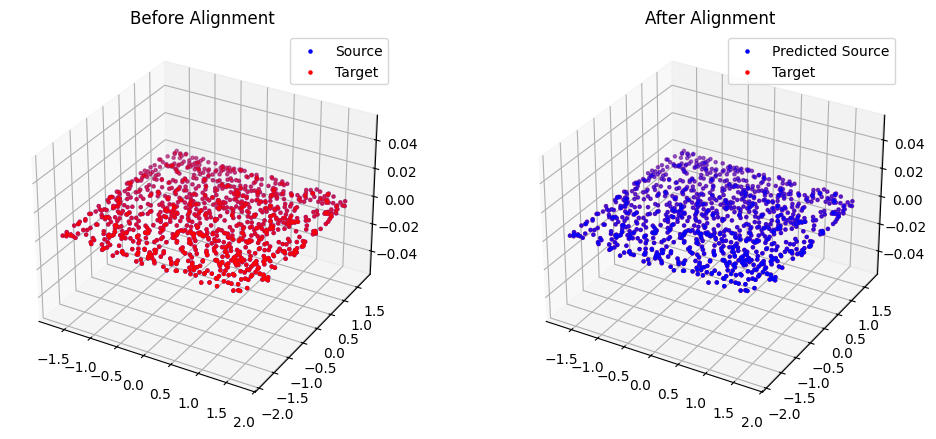

In [60]:
# Build a test loader (batch_size=1 is easiest for plotting)
test_ds = ImagePointCloudDataset(test_dir, max_points=1024)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True)

# Show 3 examples
visualize_alignment(model, test_loader, device=opts.device, num_examples=3)


Converting The Results Into Excel Format

In [63]:
import pandas as pd

epoch_list = list(range(20))  # 0 through 19

total_losses = [
    -0.2311, -0.4743, -0.7266, -0.9949, -1.2838,
    -1.5968, -1.9361, -2.3041, -2.7009, -3.1270,
    -3.5823, -4.0664, -4.5785, -5.1194, -5.6825,
    -6.2584, -6.8351, -7.4006, -7.9300, -8.4154
]

hetero_losses = [
    -0.2346, -0.4753, -0.7280, -0.9971, -1.2863,
    -1.5992, -1.9382, -2.3057, -2.7022, -3.1280,
    -3.5830, -4.0668, -4.5788, -5.1195, -5.6825,
    -6.2585, -6.8351, -7.4006, -7.9300, -8.4154
]

chamfer_losses = [
    0.0071, 0.0021, 0.0028, 0.0043, 0.0050,
    0.0048, 0.0042, 0.0033, 0.0025, 0.0018,
    0.0013, 0.0008, 0.0005, 0.0003, 0.0002,
    0.0001, 0.0000, 0.0000, 0.0000, 0.0000
]

In [65]:
df = pd.DataFrame({
    "epoch": epoch_list,
    "total_loss": total_losses,
    "hetero_loss": hetero_losses,
    "chamfer_loss": chamfer_losses
})

csv_path = "/content/drive/MyDrive/Diffusion_Models/mini_models/training_losses.csv"
df.to_csv(csv_path, index=False)
print(f"Saved losses to {csv_path}")

Saved losses to /content/drive/MyDrive/Diffusion_Models/mini_models/training_losses.csv


Loss Dipping Vs Epochs

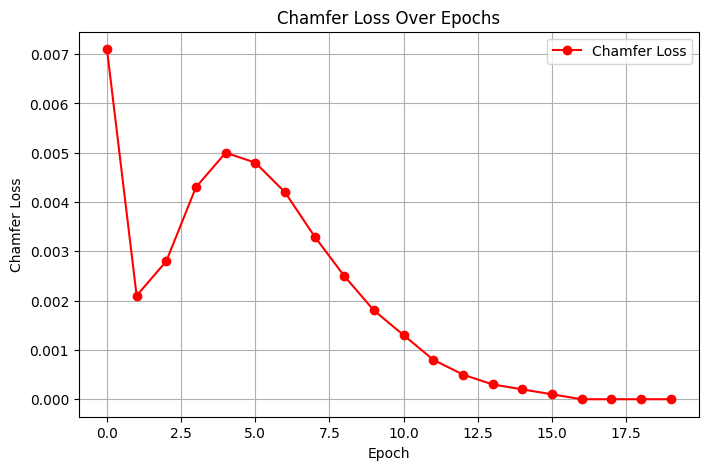

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["chamfer_loss"], marker="o", color="red", label="Chamfer Loss")
plt.xlabel("Epoch")
plt.ylabel("Chamfer Loss")
plt.title("Chamfer Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

As discussed in earlier meeting : 3 Best Epochs

In [70]:
# Sort by total_loss ascending (best = lowest)
best_df = df.nsmallest(3, "total_loss")
print("Best 3 epochs based on Total Loss:")
print(best_df)

Best 3 epochs based on Total Loss:
    epoch  total_loss  hetero_loss  chamfer_loss
19     19     -8.4154      -8.4154           0.0
18     18     -7.9300      -7.9300           0.0
17     17     -7.4006      -7.4006           0.0
